In [1]:
#Let's begin with importing the MNIST Dataset
# As by default Scikit-Learn already have Dataset

In [2]:
#Firstly update the Python, Scikit and import few Libraries we know we will be needing in the project

import sklearn
assert sklearn.__version__ >= "0.20"
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import os


In [3]:
from sklearn.datasets import fetch_openml as fetopml

mnist=fetopml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
#Let's quick peak 
X,y=mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [5]:
#70,000 dataset with 784 features 
#we can take 60,000 as training Dataset


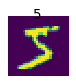

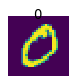

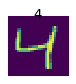

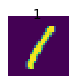

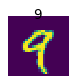

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

for x in range(5):
    digits=X[x]
    digits_img=digits.reshape(28,28)
    plt.figure(num=y[x], figsize=(1,1), dpi=80)
    plt.suptitle(y[x])
    plt.imshow(digits_img)
    plt.axis("off")
    plt.show()



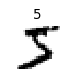

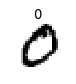

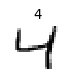

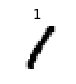

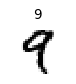

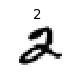

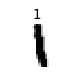

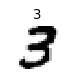

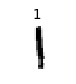

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

for x in range(9):
    digits=X[x]
    digits_img=digits.reshape(28,28)
    plt.figure(num=y[x], figsize=(1,1), dpi=80)
    plt.suptitle(y[x])
    plt.imshow(digits_img,cmap='binary')
    plt.axis("off")
    plt.show()


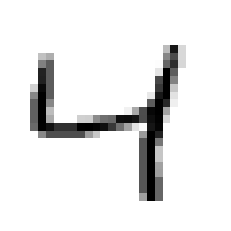

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digits=X[2]
some_digits_img=some_digits.reshape(28,28)
plt.imshow(some_digits_img,cmap='binary')
plt.axis("off")
plt.show()

In [23]:
#Since the dataset is already shuffled and independent of biasing so we will simply slice the array in Training and Test set
x_train,x_test=X[:60000], X[60000:]
y_train,y_test=y[:60000], y[60000:]

In [24]:
#Lets try to make a Binary Classifier to check the Digit 4
y_train = y_train.astype(np.int8)
y_train_4=(y_train==4)
y_test_4=(y_test==4)



In [25]:
#let try to work out with the Stochastic Gradient Descent classier
#We will be using it as Binary Classifier i.e. we will check whether the figure is 7 or not 7
from sklearn.linear_model import SGDClassifier 

sgd=SGDClassifier(max_iter=1000, tol=1e-3,random_state=42)
sgd.fit(x_train, y_train_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
sgd.predict([some_digits])

array([ True])

In [27]:
#Check the accuracy by cross validation the Binary SGD Classifier

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds=StratifiedKFold(n_splits=3)

for train_index,test_index in skfolds.split(x_train,y_train_4):
    clone_clf=clone(sgd)
    x_train_folds=x_train[train_index]
    y_train_folds=y_train_4[train_index]
    
    x_test_folds=x_train[test_index]
    y_test_folds=y_train_4[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred=clone_clf.predict(x_test_folds)
    n_correct=sum(y_pred==y_test_folds)
    print("Accuracy::",n_correct/len(y_pred))

Accuracy:: 0.9671
Accuracy:: 0.97645
Accuracy:: 0.9687


In [16]:
from sklearn.model_selection import cross_val_score as cvs

cvs(sgd,x_train,y_train_4,cv=3,scoring="accuracy")


array([0.9671 , 0.97645, 0.9687 ])

In [37]:
#lets Check the NOT-4 prediction accuracy of the model
from sklearn.base import BaseEstimator 

class Not4clf(BaseEstimator):
    def fit(self,x,y=None):
        return self;
    
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)



In [38]:
#Let's test the accuracy of how well we can predict that the value isn't " 4 "
from sklearn.model_selection import cross_val_score as cvs

never_4=Not4clf()
cvs(never_4,x_train,y_train_4,cv=3,scoring="accuracy")

array([0.90275, 0.9018 , 0.90335])

In [42]:
#Let's create the CONFUSION MATRIX 
from sklearn.model_selection import cross_val_predict as cvs

y_train_pred=cvs(sgd,x_train,y_train_4,cv=3)
y_train_pred

array([False, False,  True, ..., False, False, False])

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4,y_train_pred)

array([[52957,  1201],
       [  554,  5288]], dtype=int64)

In [46]:
from sklearn.metrics import confusion_matrix

y_train_perfect_predictions=y_train_4

confusion_matrix(y_train_4,y_train_perfect_predictions)

array([[54158,     0],
       [    0,  5842]], dtype=int64)

In [49]:
# Checking up the binary classifer on Precision and Recall
from sklearn.metrics import precision_score as prsc , recall_score as resc

print("Precision Score::",prsc(y_train_4,y_train_pred))

print("Recall Score::",resc(y_train_4,y_train_pred))

Precision Score:: 0.8149175527816305
Recall Score:: 0.905169462512838


In [51]:
from sklearn.metrics import f1_score 

f1_score(y_train_4,y_train_pred)

0.8576757764982564

In [53]:
y_scores=sgd.decision_function([some_digits])
y_scores

array([3214.66574913])

In [56]:
# Changing the Threshold value for the Precision/Recall Trade off and calibrate it to the best possible combination of P/R 
threshold=0
y_some_digits_pred=(y_scores>threshold)
y_some_digits_pred


array([ True])

In [61]:
threshold=5000
y_some_digits_pred=(y_scores>threshold)
y_some_digits_pred


array([False])

In [63]:
# HIT & TRIAL can take very long time to find the accurate P/R Trade off
y_scores=cvs(sgd,x_train,y_train_4,cv=3,method="decision_function")
y_scores

array([-31754.76525516, -26393.82888302,   2160.11030898, ...,
       -19439.69962707, -10979.35873154, -22487.33775957])

In [65]:
# Simply we can go for P/R Curve and use our Graphical tool kit to find the optimals values
from sklearn.metrics import precision_recall_curve as prcurve

precisions,recalls,thresholds=prcurve(y_train_4,y_scores)
print("Precision::",precisions)
print("Recalls::",recalls)
print("Threshold::",thresholds)

Precision:: [0.10262626 0.1026105  0.1026123  ... 1.         1.         1.        ]
Recalls:: [1.00000000e+00 9.99828826e-01 9.99828826e-01 ... 3.42348511e-04
 1.71174255e-04 0.00000000e+00]
Threshold:: [-61778.26334052 -61768.78294136 -61764.89465536 ...  42016.20158046
  42674.90852649  44388.35162874]


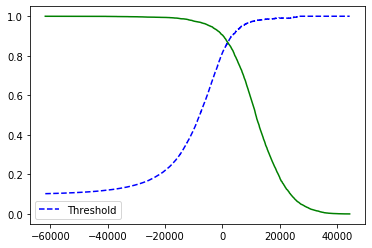

In [67]:
# Plotting the P/R Curve against Thresholds
def plot_prcurve(precisions,recalls,thresholds=0):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision vs Threshold")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall vs Threshold")
    plt.legend(["Threshold"]) 

    
plot_prcurve(precisions,recalls,thresholds) 
plt.show() 